In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score

from transformers import AutoModel, AutoTokenizer

import torch
import torch.nn as nn
import torch.nn.functional as F


from tqdm.notebook import tqdm
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
torch.cuda.empty_cache()

In [5]:
train_raw = pd.read_csv('/kaggle/input/bytedatahack-22/train.csv')
train_raw = train_raw[train_raw['target'] != -1]
targets = train_raw['target'].values

In [6]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
emb_model = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
emb_model.to(device)  # uncomment it if you have a GPU

def embed_bert_cls(text, model=emb_model, tokenizer=tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings.cpu().numpy()

Some weights of the model checkpoint at cointegrated/rubert-tiny2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
embed_bert_cls(['hello world', 'hi how are you']).shape

(2, 312)

In [8]:
class BertVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        texts = list(X['full_description'].values)
        self.t = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
        self.model.eval()
        with torch.no_grad():
            model_output = self.model(**{k: v.to(self.model.device) for k, v in self.t.items()})
        embeddings = model_output.last_hidden_state[:, 0, :]
        embeddings = torch.nn.functional.normalize(embeddings)
        return embeddings.cpu().numpy()
    
class FullDescriptionCreator(BaseEstimator, TransformerMixin):
    """Добавляет столбец с полным описанием вакансии"""

    patt = re.compile("[^\s\w]")

    def __init__(self, responsibilities):
        self.responsibilities = responsibilities

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = pd.merge(X, self.responsibilities, left_on='index', right_index=True, how='left')
        X["full_description"] = (
            X["name"] + " " + X["responsibilities"].fillna("")
        ).map(str.lower)
        X.loc[:, "full_description"] = X["full_description"].str.replace(
            self.patt, " ", regex=True
        )
        return X
    
class ClearHTML(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        CLEANR = re.compile('<.*?>') 
        
        X = X.copy()
        X['description'] = X['description'].astype(str)
        X['description'] = X['description'].apply(lambda raw_html: re.sub(CLEANR, '', raw_html))
        return X

class FillEmpty(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X.loc[X['description'].isnull(), 'description'] = X[X['description'].isnull()]['name']
        X['description'] = X['description'].str.replace('\n', ' ')
        return X

In [10]:
import json
import os
descriptions = []

DIR_PATH = '/kaggle/input/bytedatahack-22/vacancy_descriptions'

for filename in os.listdir(DIR_PATH):
    with open(os.path.join(DIR_PATH, filename),'r', encoding='utf8') as fp:
        descriptions += json.load(fp)
    break
responsibilities = pd.Series(
    {
        description["ID"]: description["Content"].get("Обязанности")[0]
        if (description["Content"].get("Обязанности")) is not None
        else None
        for description in descriptions
    },
    name="responsibilities",
)

In [11]:
len(descriptions)

10001

In [12]:
pipeline = make_pipeline(ClearHTML(), FillEmpty(), FullDescriptionCreator(responsibilities=responsibilities), BertVectorizer(emb_model, tokenizer))

In [13]:
okz = pd.read_csv('/kaggle/input/bytedatahack-22/okz_3_4_professions.csv', sep='	')
n_classes = len(okz['code'].unique())

le = LabelEncoder()
le.fit(okz['code'].values)

LabelEncoder()

In [19]:
train_data = pipeline.fit_transform(train_raw)
train_data.shape

RuntimeError: CUDA out of memory. Tried to allocate 118.00 MiB (GPU 0; 14.76 GiB total capacity; 13.88 GiB already allocated; 87.75 MiB free; 13.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_raw, le.transform(targets))

In [16]:
def iter_batches(X, y=None, batch_size=256, shuffle=False):
    indecies = np.arange(len(X))
    
    if shuffle:
        indecies = np.random.permutation(indecies)
    
    for i in range(0, len(X), batch_size):
        X_batch = X.iloc[indecies[i:i+batch_size]]
        
        if type(y) != type(None):
            y_batch = y[indecies[i:i+batch_size]]
            yield X_batch, y_batch
        else:
            yield X_batch

In [15]:
first_batch = next(iter_batches(X_train, y_train))

In [16]:
FullDescriptionCreator(responsibilities=responsibilities).fit_transform(FillEmpty().fit_transform(ClearHTML().fit_transform(first_batch[0])))

,index,name,description,target,responsibilities,full_description
3438,170044141,менеджер по закупкам,"Компания основана в 2008 году, в Казани. Сегод...",3323,работа со входящими звонками корректировка точ...,менеджер по закупкам работа со входящими звонк...
20095,38200192,дояр,"Машинное и ручное доение коров, массаж, подмыв...",6121,"Машинное и ручное доение коров, массаж, подмыв...",дояр машинное и ручное доение коров массаж п...
4859,166664292,курьер в доставку продуктов,ТРЕБУЕТСЯ ВЕЛОКУРЬЕРЫ (ВЕЛОСИПЕДЫ ВЫДАЕМ) Опис...,9621,None,курьер в доставку продуктов
15832,179273196,подсобный рабочий,Без опыта работы Рабочий (г. Пенза),9622,None,подсобный рабочий
27538,113756830,продавец консультант на частичную занятость в ...,"на частичную занятость Мы – самая стильная, мо...",5223,Консультирование клиентов по ассортиментному р...,продавец консультант на частичную занятость в ...
...,...,...,...,...,...,...
8007,278335469,лесовод,Подготовительные и вспомогательные работы по п...,6210,подготовительные и вспомогательные работы по п...,лесовод подготовительные и вспомогательные раб...
5579,91335152,упаковщик,Требуется упаковщик картин на неделю. Работа с...,9321,Упаковывать картины студии в стрейч-пленку и д...,упаковщик упаковывать картины студии в стрейч ...
28261,78510679,офис менеджер отдела продаж,Рельеф-Центр – федеральная торгово-производс...,3341,эффективное взаимодействие с клиентами компани...,офис менеджер отдела продаж эффективное взаимо...
13114,392236789,оператор машинного доения,"Уход за животными,кормление, машинное доение к...",6121,"Уход за животными,кормление, машинное доение к...",оператор машинного доения уход за животными ко...


In [52]:
class MLP(nn.Module):
    def __init__(self, n_hidden=100, n_emb=312, n_classes=n_classes):
        super().__init__()
        self.fc1 = nn.Linear(n_emb, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        return self.fc2(F.relu(x))

In [53]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr=5e-5)

lossi = []

In [54]:
torch.tensor(X, device=device)

tensor([[-0.0688,  0.0056,  0.0910,  ...,  0.1218,  0.0657, -0.0516],
        [-0.0617, -0.0432, -0.0439,  ...,  0.0088,  0.0957, -0.0304],
        [-0.0260,  0.0325, -0.0167,  ...,  0.0060,  0.0497, -0.0529],
        ...,
        [ 0.0244, -0.0031, -0.0352,  ..., -0.0214,  0.1207, -0.0433],
        [ 0.0284,  0.0395,  0.0051,  ...,  0.0453,  0.0074, -0.0329],
        [-0.0407, -0.0049,  0.0399,  ...,  0.0802,  0.0591, -0.0322]],
       device='cuda:0')

In [107]:
BATCH_SIZE = 10
EPOCHS = 100

progress_bar = tqdm(range(len(X_train ) * EPOCHS))


for _ in range(EPOCHS):
    for X_batch, y_batch in iter_batches(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True):
        X = pipeline.fit_transform(X_batch)
        logits = model(torch.tensor(X, device=device))

        optim.zero_grad()
        loss = criterion(logits, torch.tensor(y_batch, device=device))

        loss.backward()
        optim.step()
        progress_bar.update(BATCH_SIZE) 

        lossi.append(loss)

  0%|          | 0/1173700 [00:00<?, ?it/s]

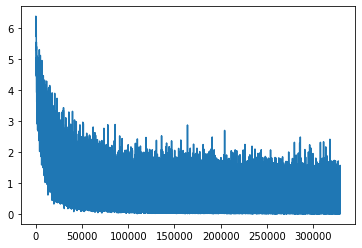

In [108]:
plt.plot(range(len(lossi)), list(map(lambda x: x.item(), lossi)))

In [109]:
preds = []
progress_bar = tqdm(range(len(X_test)))

for X_batch in iter_batches(X_test, batch_size=BATCH_SIZE):
    X = pipeline.fit_transform(X_batch)
    logits = model(torch.tensor(X, device=device))
    pred = F.softmax(logits, dim=-1)
    preds.append(pred)
    
    progress_bar.update(BATCH_SIZE)

  0%|          | 0/3913 [00:00<?, ?it/s]

In [110]:
preds = torch.cat(preds)
compute_metrics(preds.detach().cpu().numpy().argmax(-1), y_test)

{'F1': 0.6222461678621268, 'accuracy_score': 0.8944543828264758}

In [46]:
{'F1': 0.6132679317842441, 'accuracy_score': 0.8829542550472783}


{'F1': 0.0022117229285883127, 'accuracy_score': 0.1037567084078712}

In [111]:
torch.save(model.state_dict(), 'bert_mlp_4')

In [1]:
from catboost import (CatBoostClassifier, Pool, sum_models,)
models = []
BATCH_SIZE = 50
progress_bar = tqdm(range(int(len(X_train)/BATCH_SIZE)+1))

# training parameters

params = {
    'task_type': 'GPU',
    'iterations': 2
}


for X_batch, y_batch in iter_batches(X_train, y_train, batch_size=BATCH_SIZE):
    X = pipeline.fit_transform(X_batch)
    batch = Pool(X, label=y_batch)
    
    model = CatBoostClassifier( **params)
    model.fit(X=batch, verbose=0)
    
    models.append(model)
    progress_bar.update(1)    

NameError: name 'tqdm' is not defined

In [18]:
clf = CatBoostClassifier(task_type='GPU', iterations=2000)

X = pipeline.fit_transform(X_train)
clf.fit(X, y_train, verbose=True)

RuntimeError: CUDA out of memory. Tried to allocate 13.46 GiB (GPU 0; 14.76 GiB total capacity; 13.88 GiB already allocated; 87.75 MiB free; 13.94 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [45]:
def compute_metrics(preds, targets):
    f1 = f1_score(targets, preds, average='macro')
    accuracy = accuracy_score(targets, preds)
    return {'F1': f1, 'accuracy_score': accuracy}

In [25]:
val_predictions = model.predict(X_test)
val_predictions.shape

(3913, 1)

In [26]:
val_predictions.flatten()

array([386, 437, 138, ..., 409, 553, 293])

In [27]:
compute_metrics(val_predictions.flatten(), y_test)

{'F1': 0.7096720652711482, 'accuracy_score': 0.9460771786353182}

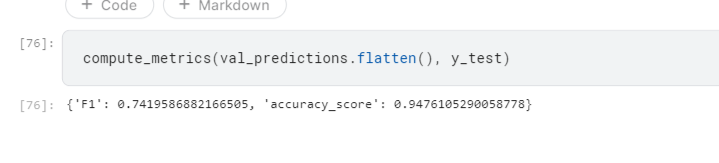

# Now I want to retrain the model on the full train_dataset

In [77]:
eval_model = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')

eval_model.fit(train_data,
          le.transform(targets),
          verbose=True)

Learning rate set to 0.113753
0:	learn: 3.1488731	total: 193ms	remaining: 3m 13s
1:	learn: 2.7331589	total: 346ms	remaining: 2m 52s
2:	learn: 2.4572115	total: 514ms	remaining: 2m 50s
3:	learn: 2.2235813	total: 665ms	remaining: 2m 45s
4:	learn: 2.0737021	total: 809ms	remaining: 2m 40s
5:	learn: 1.9076020	total: 1.04s	remaining: 2m 52s
6:	learn: 1.7533309	total: 1.22s	remaining: 2m 53s
7:	learn: 1.6541031	total: 1.38s	remaining: 2m 51s
8:	learn: 1.5541970	total: 1.53s	remaining: 2m 48s
9:	learn: 1.4591258	total: 1.71s	remaining: 2m 48s
10:	learn: 1.3881133	total: 1.87s	remaining: 2m 48s
11:	learn: 1.3096871	total: 2.03s	remaining: 2m 47s
12:	learn: 1.2559538	total: 2.18s	remaining: 2m 45s
13:	learn: 1.1904903	total: 2.35s	remaining: 2m 45s
14:	learn: 1.1321406	total: 2.51s	remaining: 2m 45s
15:	learn: 1.0831556	total: 2.67s	remaining: 2m 44s
16:	learn: 1.0330240	total: 2.84s	remaining: 2m 44s
17:	learn: 0.9877021	total: 3.01s	remaining: 2m 44s
18:	learn: 0.9461246	total: 3.17s	remaining:

In [78]:
eval_model

In [79]:
test_raw = pd.read_csv('/kaggle/input/bytedatahack-22/test.csv')
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1090 entries, 0 to 1089
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        1090 non-null   int64 
 1   name         1090 non-null   object
 2   description  1090 non-null   object
dtypes: int64(1), object(2)
memory usage: 25.7+ KB


In [80]:
test_data = pipeline.transform(test_raw)

In [82]:
preds = eval_model.predict(test_data)
result = pd.DataFrame(dict(index=test_raw['index'], target=le.inverse_transform(preds.flatten())))
result.to_csv('submission.csv', index=None)